<a href="https://colab.research.google.com/github/amirhossein1376/ml-final-project/blob/main/ml_final_project_ph2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
#Notebook
from google.colab import drive
from IPython.display import display

#NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

#ML
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix, adjusted_rand_score, homogeneity_score
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

#Other
from collections import Counter
import re
import json
import random
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Mount Drive**

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Config**

In [ ]:
config = {
    "train_dataset_path" : "/content/gdrive/MyDrive/ML/dataset.csv",
    "train_dataset_path_2" : "/content/gdrive/MyDrive/ML/dataset_2.csv",
    "word2vec_path" : "/content/gdrive/MyDrive/ML/word2vec-google-news-300.gz",
    "contractions_path" : "/content/gdrive/MyDrive/ML/contractions.json",
    "model_save_path" : "/content/gdrive/MyDrive/ML/models/"
}

**Read Data**

In [ ]:
all_df_1 = pd.read_csv(config["train_dataset_path"])

In [ ]:
with open(config["contractions_path"]) as f:
    english_contractions = dict(json.load(f).items())
    contractions_re = re.compile('(%s)' % '|'.join(english_contractions.keys()))

**Convert Labels To Binary Numbers**

In [ ]:
all_df_1['sentiment'] = all_df_1['sentiment'].apply(lambda x : 0 if x=="negative" else 1)

In [ ]:
all_df_1.head()

,comment,sentiment
0,"Oh my god, it just doesn't get any worse than ...",0
1,If you're a layman interested in quantum theor...,0
2,It's amazing that this no talent actor Chapa g...,0
3,This must be one of the most overrated Spanish...,0
4,Some critics have compared Chop Shop with the ...,1


**Preprocessing**

In [ ]:
class PreprocessorType:
    WITHOUT_PREPROCESSING = 0
    ELEMENTARY_PREPROCESSING = 1
    ADVANCED_PREPROCESSING = 2

    def get_name(t):
        if t == PreprocessorType.WITHOUT_PREPROCESSING:
            return "Without Preprocessing"
        elif t == PreprocessorType.ELEMENTARY_PREPROCESSING:
            return "Elementary Preprocessing"
        elif t == PreprocessorType.ADVANCED_PREPROCESSING:
            return "Advanced Preprocessing"
    
class Preprocessor:

    def __init__(self, preprocess_type):
        self.preprocess_type = preprocess_type
        self.stop_words = stopwords.words('english')
        self.porter = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def process_with_elementary_preprocessing(self):
        self.data = self.data.apply(lambda x: x.lower())
        self.data = self.data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
        self.data = self.data.apply(lambda x : word_tokenize(x))
        self.data = self.data.apply(lambda tkns : [word for word in tkns if word.isalpha()])
        
    def process_with_advanced_preprocessing(self, without_stem_lemma):
        self.data = self.data.apply(lambda txt : BeautifulSoup(txt, "lxml").text)
        self.data = self.data.apply(lambda txt : contractions_re.sub(lambda match : english_contractions[match.group(0)], txt))
            
        self.data = self.data.apply(lambda x: re.sub(r'[\w.+-]+@[\w-]+\.[\w.-]+', 'EMAIL_ADD',x))
        self.data = self.data.apply(lambda x: re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", 'URL_ADD', x))

        self.process_with_elementary_preprocessing()

        if without_stem_lemma:
            self.data = self.data.apply(lambda tkns : [word for word in tkns if word not in self.stop_words])            
        else:
            self.data = self.data.apply(lambda tkns : [self.porter.stem(self.lemmatizer.lemmatize(word)) for word in tkns if word not in self.stop_words])            
    def process(self, data, without_stem_lemma=False):
        self.data = data.copy()
        
        if self.preprocess_type == PreprocessorType.ADVANCED_PREPROCESSING:
            self.process_with_advanced_preprocessing(without_stem_lemma)
            self.data = self.data.apply(lambda tkns : ' '.join(tkns))

        elif self.preprocess_type == PreprocessorType.ELEMENTARY_PREPROCESSING:
            self.process_with_elementary_preprocessing()
            self.data = self.data.apply(lambda tkns : ' '.join(tkns))

        return self.data

In [ ]:
class Model:
    MLP = 4

    def get_name(m):
        if m == Model.MLP:
            return "Multi Layer Perceptron"
            
def show_grid_res(grid):
    res = pd.DataFrame(grid.cv_results_)
    res = res.filter(regex='param_.*|mean_test_score|rank_test_score').sort_values('rank_test_score')
    return res

def analysis(labels, predictions):
    print("Classification Report : \n", classification_report(labels, predictions, target_names=["negative", "positive"]))
    print("Confusion Matrix : \n", confusion_matrix(labels, predictions))
    print("Accuracy : \n", accuracy_score(labels, predictions))
    print("F1 : \n", f1_score(labels, predictions))

# **1 (Clustering)**

Prepare data to feed into MLP

In [ ]:
preprocessor = Preprocessor(PreprocessorType.ADVANCED_PREPROCESSING)
current_df_1 = all_df_1.copy()
current_df_1["comment"] = preprocessor.process(current_df_1["comment"])

In [ ]:
train_df_1 , test_df_1 = train_test_split(current_df_1, test_size=0.1, random_state=42)

vectorizer_1 = CountVectorizer(lowercase=False, min_df=10, token_pattern=r"[^\s]+")
vectorizer_1.fit(train_df_1["comment"].tolist())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=10,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='[^\\s]+', tokenizer=None,
                vocabulary=None)

Load MLP Model From First Phase

In [ ]:
mlp = joblib.load(config["model_save_path"] + 'best.pkl')

Calculate MLP Last Layer Output Values

In [ ]:
true_labels = current_df_1["sentiment"]
X_all = vectorizer_1.transform(current_df_1["comment"])

In [ ]:
hidden_layer_sizes = mlp.hidden_layer_sizes
current_outputs = np.maximum(X_all.dot(mlp.coefs_[0]), 0)
for item in mlp.coefs_[1:-1]:
    current_outputs = np.maximum(np.dot(current_outputs, item), 0)

In [ ]:
data_std = StandardScaler().fit_transform(current_outputs)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_std)

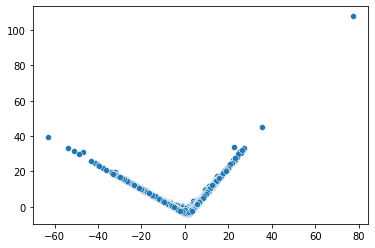

In [ ]:
sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1])

In [ ]:
def draw(PCA_components, labels, algo):
   sns.scatterplot(x=PCA_components[:, 0], y=PCA_components[:, 1], hue=labels).set(title=f'{algo}\n Homogeneity Score: {homogeneity_score(true_labels, labels)}\n Rand Score: {adjusted_rand_score(true_labels, labels)}')

### **Kmeans with 2 and 3 clusters**

In [ ]:
kmeans_2_labels = KMeans(n_clusters=2, random_state=0).fit_predict(current_outputs)

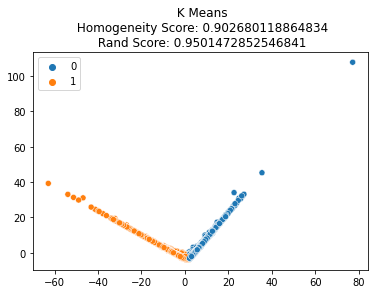

In [ ]:
draw(principalComponents, kmeans_2_labels, " K Means")

In [ ]:
kmeans_3_labels = KMeans(n_clusters=3, random_state=0).fit_predict(current_outputs)

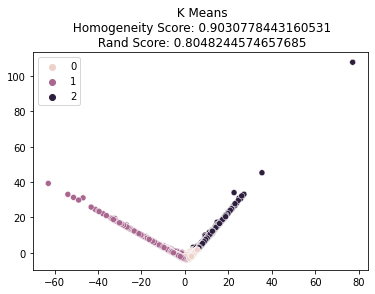

In [ ]:
draw(principalComponents, kmeans_3_labels, " K Means")

### **Minibatch Kmeans with 2 and 3 clusters**

In [ ]:
mk_2_labels = MiniBatchKMeans(n_clusters=2).fit_predict(current_outputs)

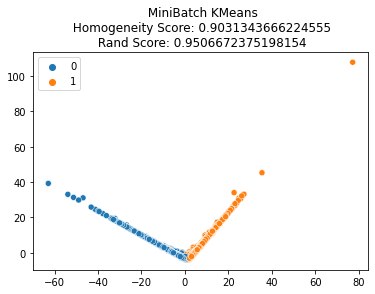

In [ ]:
draw(principalComponents, mk_2_labels, " MiniBatch KMeans")

In [ ]:
mk_3_labels = MiniBatchKMeans(n_clusters=3).fit_predict(current_outputs)

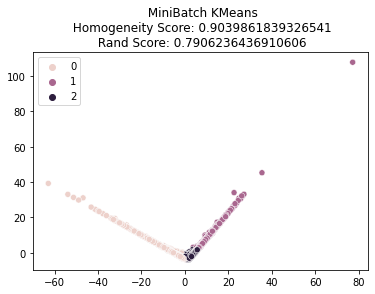

In [ ]:
draw(principalComponents, mk_3_labels, " MiniBatch KMeans")

### **Gaussian Mixture Model with 2 and 3 clusters**

In [ ]:
gm_2_labels = GaussianMixture(n_components=2, random_state=0).fit_predict(current_outputs)

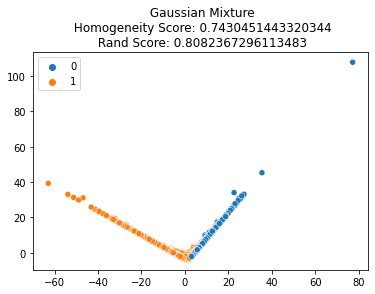

In [ ]:
draw(principalComponents, gm_2_labels, " Gaussian Mixture")

In [ ]:
gm_3_labels = GaussianMixture(n_components=3, random_state=0).fit_predict(current_outputs)

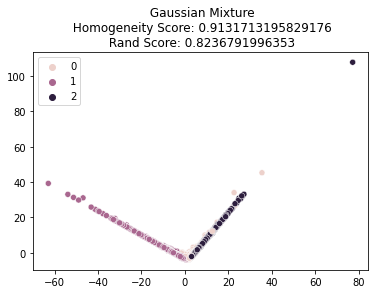

In [ ]:
draw(principalComponents, gm_3_labels, " Gaussian Mixture")

**Generate samples from each cluster in minibatch k means algorithm**

In [ ]:
indices = [np.where(mk_3_labels == 0), np.where(mk_3_labels == 1), np.where(mk_3_labels == 2)]
for idx, label in enumerate(indices):
    print(f"\n****   CLASS:{idx}   *******")
    print(all_df_1.iloc[random.choice(label[0])]["comment"])
    print("****")
    print(all_df_1.iloc[random.choice(label[0])]["comment"])


****   CLASS:0   *******
First, let me make it clear that I'm a big fan of bad sci-fi, especially when it involves gigantic, city-stomping monsters. But this one is so fantastically lame that I can't even like it for being bad. They apparently didn't shave enough money off the budget by skimping on the props (the only prop we have to indicate the size of the alien girl is an oversized novelty pencil, available at Spencer's Gifts for about fifteen bucks), they also decided not to outlay for concept or plot. The monster DOES look okay, in my opinion, but it doesn't have enough interaction with the backgrounds, i.e. not enough destruction to suit most fans of the genre. The general rule of giant monster movies is: If you don't have a lot of fake-looking buildings to smash, then you'd better have another fake-looking monster to wrestle with. This movie has neither. I can't make my final complaint about the movie without giving away the ending, but suffice to say the origin of the monster,

# **2 (Fine Tuning)**


### **A (MLP)**

**Read Second Dataset**

In [ ]:
all_df_2 = pd.read_csv(config["train_dataset_path_2"])

In [ ]:
all_df_2.head()

,comment,sentiment
0,"This is bad..: It has every cliched ""gang"",""ba...",0
1,It's his training day.: I saw this movie on tv...,0
2,The most mundane cliched junk I've seen in a l...,0
3,(;D): The headline summarizes the movie! Denze...,1
4,Too much unbelievability: Denzel is a great ac...,0


**Preprocess Second Dataset**

In [ ]:
preprocessor = Preprocessor(PreprocessorType.WITHOUT_PREPROCESSING)
current_df_2 = all_df_2.copy()
current_df_2["comment"] = preprocessor.process(current_df_2["comment"])

**Split Second Dataset to Train and Test sets**

In [ ]:
train_df_2 , test_df_2 = train_test_split(current_df_2, test_size=0.05, random_state=42)

vectorizer_2 = CountVectorizer(lowercase=False, min_df=1, token_pattern=r"[^\s]+")
vectorizer_2.fit(train_df_2["comment"].tolist())

X_train_2 = vectorizer_2.transform(train_df_2["comment"])
y_train_2 = train_df_2["sentiment"].tolist()
X_test_2 = vectorizer_2.transform(test_df_2["comment"])
y_test_2 = test_df_2["sentiment"].tolist()

**Apply MLP Model On Second Dataset**

In [ ]:
settings = {
    Model.MLP : {
        "hidden_layer_sizes" : [(100, 100), (100, 200, 50), (450, 100, 50), (400, 500, 400, 200, 100, 50)]
    }
}

In [ ]:
grid_d2v_mlp = GridSearchCV(MLPClassifier(max_iter=2000),settings[Model.MLP],scoring='accuracy',n_jobs=-1, verbose=3)
grid_d2v_mlp.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   32.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   32.3s finished


In [ ]:
show_grid_res(grid_d2v_mlp)

,param_hidden_layer_sizes,mean_test_score,rank_test_score
0,"(100, 100)",0.810526,1
2,"(450, 100, 50)",0.806316,2
1,"(100, 200, 50)",0.791579,3
3,"(400, 500, 400, 200, 100, 50)",0.785263,4


In [ ]:
grid_predictions = grid_d2v_mlp.predict(X_test_2)
analysis(y_test_2, grid_predictions)

Classification Report : 
               precision    recall  f1-score   support

    negative       1.00      0.71      0.83        14
    positive       0.73      1.00      0.85        11

    accuracy                           0.84        25
   macro avg       0.87      0.86      0.84        25
weighted avg       0.88      0.84      0.84        25

Confusion Matrix : 
 [[10  4]
 [ 0 11]]
Accuracy : 
 0.84
F1 : 
 0.846153846153846


### **B (Fine Tune)**

In [ ]:
train_df_2 , test_df_2 = train_test_split(current_df_2, test_size=0.2, random_state=42)

X_train_1 = vectorizer_1.transform(train_df_1["comment"])
y_train_1 = train_df_1["sentiment"].tolist()
X_train_2 = vectorizer_1.transform(train_df_2["comment"])
y_train_2 = train_df_2["sentiment"].tolist()
X_test_1 = vectorizer_1.transform(test_df_1["comment"])
y_test_1 = test_df_1["sentiment"].tolist()
X_test_2 = vectorizer_1.transform(test_df_2["comment"])
y_test_2 = test_df_2["sentiment"].tolist()

In [ ]:
import pickle
mlp = pickle.load(open(config["model_save_path"] + 'best.pkl', 'rb'))

In [ ]:
for _ in range(2):
    mlp.fit(X_train_2, y_train_2)

In [ ]:
predictions_2 = mlp.predict(X_test_1)
analysis(y_test_1, predictions_2)

Classification Report : 
               precision    recall  f1-score   support

    negative       0.84      0.91      0.87      2225
    positive       0.91      0.82      0.86      2275

    accuracy                           0.87      4500
   macro avg       0.87      0.87      0.87      4500
weighted avg       0.87      0.87      0.87      4500

Confusion Matrix : 
 [[2033  192]
 [ 401 1874]]
Accuracy : 
 0.8682222222222222
F1 : 
 0.8633955309836443
